In this tutorial, we will be using the following datasets for demonstration:
- Brain MRI provided by the [IXI dataset](https://brain-development.org/ixi-dataset/) distrubuted under the [CC BY-SA 3.0 License](https://creativecommons.org/licenses/by-sa/3.0/)

- CT scan of a subject contained in the medical segmentation decathlon lung tumor segmentation challenge (http://medicaldecathlon.com/, https://arxiv.org/abs/1902.09063) distrubuted under the [CC BY-SA 4.0 License](https://creativecommons.org/licenses/by-sa/4.0/)

In [2]:
# Importing required libraries

import nibabel as nib
import nibabel.processing
import numpy as np
import matplotlib.pyplot as plt

## Basic 3D Image Processing

Here, we load in NIfTI formatted files for easier demonstration of the techniques.

In [3]:
brain_mri = nib.load("data/IXI662-Guys-1120-T1.nii.gz")
brain_mri_data = brain_mri.get_fdata()

In [4]:
shape = brain_mri.shape
print(shape)

(256, 256, 150)


### Dataset Visualization

An affine matrix is a 4×4 matrix that defines the transformation from pixel/voxel coordinates to cartesian coordinates. The matrix's first three columns handle rotation, scaling, and shearing, while the final column is dedicated to translation.

In [5]:
affine = brain_mri.affine
print(affine)

[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00 -9.06798553e+01]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02  1.02829445e+02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11 -1.14823784e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Slicing involves extracting a specific selection of frames from a complete volumetric dataset. The orientation of the scan dictates how the indices correspond to anatomical planes. Consequently, the first axis might represent axial, coronal, or sagittal slices depending on the acquisition.

In [6]:
nib.aff2axcodes(affine)

('P', 'S', 'R')

In this case, the orientation of the scan is:
* **from anterior to posterior (from front to back)**
* **from inferior to superior (from bottom to top)**
* **from left to right**

The letters returned from aff2axcodes always indicate the end of the corresponding axis.

This also explains why the scan is upside down, when slicing along the fist axis (coronal). As the second axis moves from the bottom to the top, the first slice is **not** the top of the head, but some part of the neck.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

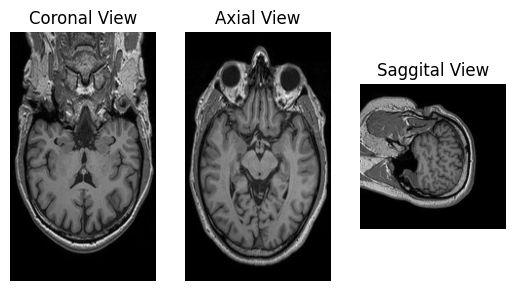

In [36]:
plt.figure()
plt.subplot(131)
plt.imshow(brain_mri_data[120, :, :], cmap="gray")
plt.title('Coronal View')
plt.axis('off')

plt.subplot(132)
plt.imshow(brain_mri_data[:, 120, :], cmap="gray")
plt.title('Axial View')
plt.axis('off')

plt.subplot(133)
plt.imshow(brain_mri_data[:, :, 120], cmap="gray")
plt.title('Saggital View')
plt.axis('off')

### Affine Transformation

To calculate where the voxel coordinates lie in the physical space, we need to do matrix multilication between the affine and the voxel xordinates.

In [8]:
voxel_coord = np.array((0, 0, 0, 1))
physical_coord0 = affine @ voxel_coord  # @ is a shortcut for matrix multiplication in numpy
print(physical_coord0)

[ -90.67985535  102.82944489 -114.82378387    1.        ]


Similarly to get the voxel coordinates from physical coordinates, we need to inverse of the affine matrix and then multiply with the physical coordinates.

In [9]:
voxel_coords = (np.linalg.inv(affine) @ physical_coord0).round()
print(voxel_coords)

[-0.  0.  0.  1.]


### Resampling

Resampling differs from simple image resizing because it involves altering the pixel/voxel size. The nibabel.processing library offers the conform(input, desired_shape, voxel_size) function specifically for resampling an image to a specified shape and voxel size.

In [21]:
voxel_size = (2, 2, 2)
brain_mri_resized = nibabel.processing.conform(brain_mri, (128, 128, 100), voxel_size, orientation="PSR")
brain_mri_resized_data = brain_mri_resized.get_fdata()

In [18]:
print(brain_mri.shape)
print(brain_mri.header.get_zooms())
print(brain_mri_resized.shape)
print(brain_mri_resized.header.get_zooms())

(256, 256, 150)
(np.float32(0.9375), np.float32(0.9375), np.float32(1.2000039))
(128, 128, 150)
(np.float32(2.0), np.float32(2.0), np.float32(2.0))


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

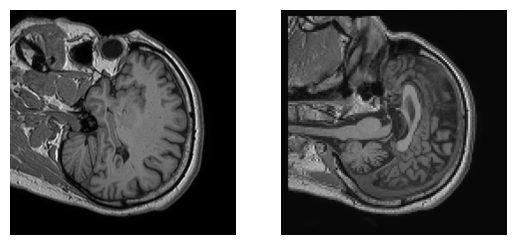

In [23]:
plt.figure()
plt.subplot(121)
plt.imshow(brain_mri_data[:, :, 50], cmap="gray")
plt.axis('off')

plt.subplot(122)
plt.imshow(brain_mri_resized_data[:, :, 50], cmap="gray")
plt.axis('off')

## Preprocessing MRI 

In [25]:
cardiac_mri = nib.load("data/la_003.nii.gz")
cardiac_mri_data = cardiac_mri.get_fdata()

MRI scans lack a fixed intensity scale, meaning voxel values can vary significantly between acquisitions. To ensure consistent input for a model, both standardization and normalization are applied during preprocessing.

In [26]:
mean, std = np.mean(cardiac_mri_data), np.std(cardiac_mri_data)
cardiac_mri_norm = (cardiac_mri_data - mean) / std
cardiac_mri_standardized = (cardiac_mri_norm - np.min(cardiac_mri_norm)) / (np.max(cardiac_mri_norm) - np.min(cardiac_mri_norm))

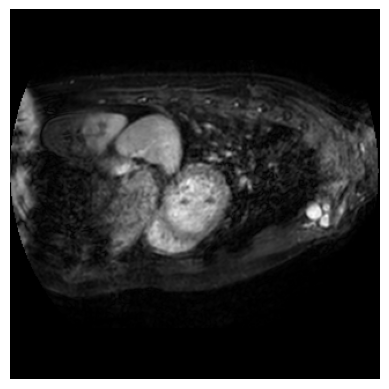

In [27]:
plt.figure()
plt.imshow(cardiac_mri_standardized[:,:,30], cmap="gray")
plt.axis('off')
plt.show()

## Preprocessing CT

CT scans operate on a fixed scale measured in Hounsfield Units (HU), typically ranging from -1000 HU (representing air) to approximately 1000 HU (representing water). Because of this inherent fixed scale, normalization (e.g., min-max scaling to a [0,1] range) is generally avoided as it would distort these meaningful, quantitative values.

However, standardization is still a valuable preprocessing step. A common approach to standardize CT data is to divide the voxel values by 3071, which corresponds to the maximum possible HU value (since the range is often considered to extend up to 3071 in some contexts, encompassing bone and other dense tissues beyond water). This scales the data to a more manageable range while largely preserving the relative intensity differences inherent to the Hounsfield scale.

In [30]:
lung_ct = nib.load("data/lung_043.nii.gz")
lung_ct_data = lung_ct.get_fdata()

In [31]:
lung_ct_data_standardized = lung_ct_data / 3071

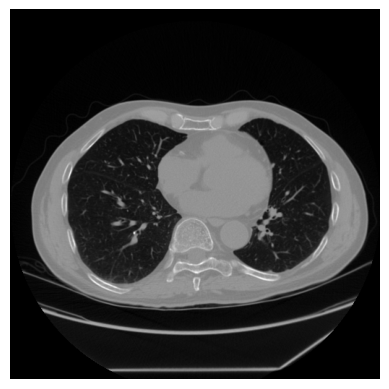

In [32]:
plt.figure()
plt.imshow(np.rot90(lung_ct_data_standardized[:,:,50]), cmap="gray")
plt.axis('off')
plt.show()

The desired contrast in medical images varies significantly depending on the clinical task. For instance, when examining the lungs, it's crucial to resolve fine details like small vessels, requiring a specific low-contrast setting. Conversely, inspecting the general body demands high contrast to clearly differentiate between various tissue types.

This adjustment of contrast is known as windowing. Typically, several specialized windows are used, including:
- Lung window (-1000 to -500)
- Bone window 
- Soft-tissue window (-250 to 250)
- Brain window

You can create these windows by clipping pixel values that fall outside a specific threshold range, effectively highlighting the tissues of interest.

In [33]:
lung_ct_lung_window = np.clip(lung_ct_data, -1000, -500)
lung_ct_soft_tissue_window = np.clip(lung_ct_data, -250, 250)

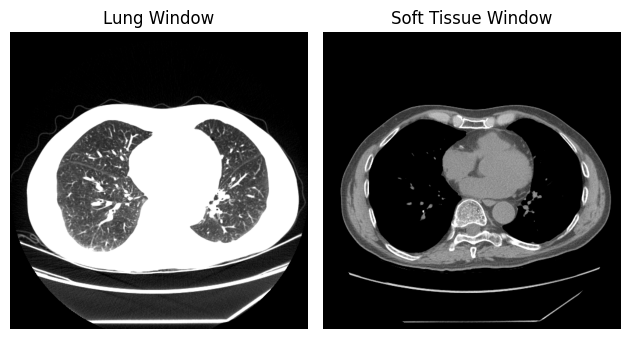

In [34]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(np.rot90(lung_ct_lung_window[:,:,50]), cmap="gray")
axis[1].imshow(np.rot90(lung_ct_soft_tissue_window[:,:,50]), cmap="gray")
axis[0].axis("off")
axis[1].axis("off")
axis[0].set_title("Lung Window")
axis[1].set_title("Soft Tissue Window")
plt.tight_layout()
plt.show()